In [126]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as pgo
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)

from scipy import stats

import mne
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import bonferroni_correction, fdr_correction
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test

from utils import bad_participant


In [41]:
#plotting parameters

grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 8  # width in inches
fig_height = 6  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1.5,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
    },
)

sns.set_palette(sns.color_palette(nt_colors))

In [140]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'


all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']


path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac
bad_participants = []
for i in all_participants:
    participant = i
    
    folder = path + participant +'/'
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif', verbose = False) 

    if bad_participant(epochs, probe= 'PC', mind = 'mind2'):
        bad_participants.append(participant)

print('List of bad participants: ', bad_participants)

good_participants = [x for x in all_participants if x not in bad_participants]
print(f'{len(good_participants)} good participants remaining')

List of bad participants:  ['VP08', 'VP09', 'VP12', 'VP14', 'VP19', 'VP20', 'VP23', 'VP25', 'VP29', 'VP30', 'VP31', 'VP32', 'VP33']
13 good participants remaining


In [141]:
channels = ['FC1', 'FCz', 'FC2', 'C1', 'Cz','C2', 'CP1', 'CPz', 'CP2']
# channels = ['Cz']
idx =  [epochs.ch_names.index(channel) for channel in channels]

In [164]:
evoked_mw = []
evoked_ot = []

prev_trial = 5

def try_except(epochs,string):
    try:
        return epochs[string]
    except:
        pass
    

for i in good_participants:
    participant = i

    folder = path + participant +'/'
    
    #############################
    #### With ERP SUBTRACTED ####
    #############################
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif', verbose = False) 
    epochs.info['description'] = 'biosemi/64' #necessary for wSMI x
    epochs =  epochs.pick_types(eeg = True) #EOGs break everything\
    
    try:
        ot_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/on-task/correct/go/{i}')for i in range(1,prev_trial)])
        evoked_ot.append(ot_epochs.average().data)
    except:
        pass
    try:
        smw_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/sMW/correct/go/{i}')for i in range(1,prev_trial)])
        dmw_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/dMW/correct/go/{i}')for i in range(1,prev_trial)])
        evoked_mw.append(mne.concatenate_epochs([smw_epochs, dmw_epochs]).average().data)
    except:
        try:
            dmw_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/dMW/correct/go/{i}')for i in range(1,prev_trial)])
            evoked_mw.append(dmw_epochs.average().data)
        except:
            try:
                smw_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/sMW/correct/go/{i}')for i in range(1,prev_trial)])
                evoked_mw.append(smw_epochs.average().data)
            except:
                pass
        
evoked_mw = np.array(evoked_mw)[:,idx,:]
evoked_ot = np.array(evoked_ot)[:,idx,:]
# evoked_mw = np.array(evoked_mw)
# evoked_ot = np.array(evoked_ot)

In [165]:
ot_grand_average = np.mean(evoked_ot, axis = 1)
mw_grand_average = np.mean(evoked_mw, axis = 1)

contrasts = [ ot_grand_average,mw_grand_average]

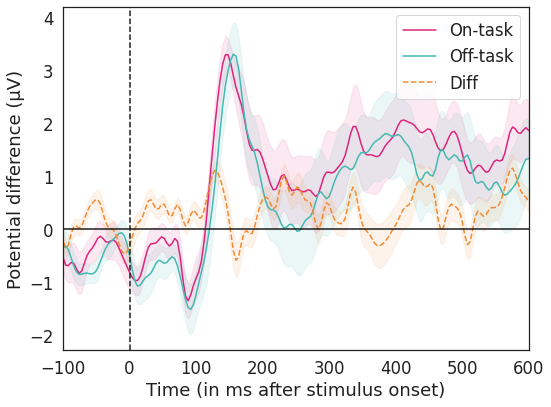

In [166]:
tmax = 0.6
scale = 1e6

diff = (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale)
# diff_std =  stats.sem(contrasts[0] - contrasts[1]) * scale

fig, ax = plt.subplots(1)


ax.plot(epochs.times * 1000, np.mean(contrasts[0],axis = 0) * scale,
        color= pink, label='On-task')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[0],axis = 0) - stats.sem(contrasts[0],axis = 0)) * scale,  
                 (np.mean(contrasts[0],axis = 0) + stats.sem(contrasts[0],axis = 0)) * scale,color= pink, alpha= 0.1)
ax.plot(epochs.times * 1000, np.mean(contrasts[1],axis = 0) * scale,
       color= lblue, label='Off-task')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[1],axis = 0) - stats.sem(contrasts[1],axis = 0)) * scale,  
                 (np.mean(contrasts[1],axis = 0) + stats.sem(contrasts[1],axis = 0)) * scale,color= lblue,alpha = 0.1)
ax.plot(epochs.times* 1000, (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale),
        color= orange,label='Diff', ls = '--')
plt.fill_between(epochs.times * 1000, diff-diff_std, diff+diff_std , color= orange,alpha = 0.1)

# ax.grid(True)
ax.set(xlim=[-100, 1000 * tmax], xlabel='Time (in ms after stimulus onset)',
#        ylim=[-12.5, 5],
       ylabel=u'Potential difference (μV)')
ax.axvline(0, ls='--', color='k')
ax.axhline(0, ls='-', color='k')

plt.legend()

fig.tight_layout(pad=0.5)


plt.savefig('Figs/erp_ot_vs_mw.png')
plt.show()

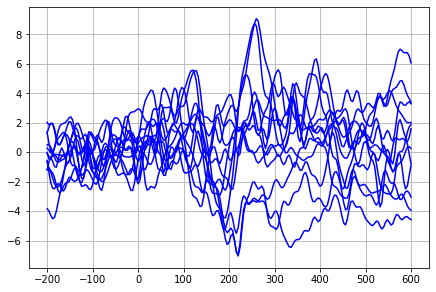

In [33]:
for i in range(12):

    scale = 1e6

    plt.plot(epochs.times * 1000, contrasts[0][i] * scale-contrasts[1][i] * scale,
            'b', label='diff')

#     ax.plot(epochs.times* 1000, (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale),
#             'b', label='diff')

plt.grid(True)
# plt.set(xlim=[-100, 1000 * tmax], xlabel='Time (in ms after stimulus onset)',
#     #        ylim=[-12.5, 5],
#         ylabel=u'Potential difference (μV)')

# plt.legend()

plt.tight_layout(pad=0.5)

plt.show()

In [161]:
T, pval = stats.ttest_ind(contrasts[0],contrasts[1], axis  =0)
alpha = 0.05

n_tests,  n_samples= np.array(contrasts[0]).shape
threshold_uncorrected = stats.t.ppf(1.0 - alpha, n_samples - 1)

reject_bonferroni, pval_bonferroni = bonferroni_correction(pval, alpha=alpha)
threshold_bonferroni = stats.t.ppf(1.0 - alpha / n_tests, n_samples - 1)

reject_fdr, pval_fdr = fdr_correction(pval, alpha=alpha, method='indep')
# threshold_fdr = np.min(np.abs(T)[reject_fdr])

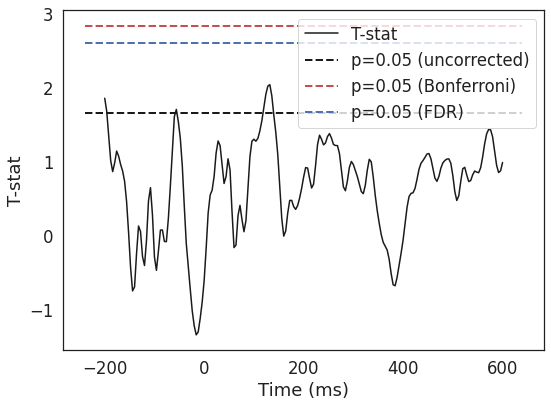

In [162]:
times = 1e3 * epochs.times

plt.close('all')
plt.plot(times, T, 'k', label='T-stat')
xmin, xmax = plt.xlim()
plt.hlines(threshold_uncorrected, xmin, xmax, linestyle='--', colors='k',
           label='p=0.05 (uncorrected)', linewidth=2)
plt.hlines(threshold_bonferroni, xmin, xmax, linestyle='--', colors='r',
           label='p=0.05 (Bonferroni)', linewidth=2)
plt.hlines(threshold_fdr, xmin, xmax, linestyle='--', colors='b',
           label='p=0.05 (FDR)', linewidth=2)
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("T-stat")
plt.show()

In [14]:
from mne.stats import spatio_temporal_cluster_test


In [38]:
threshold = None
adjacency, ch_names = find_ch_adjacency(epochs.info, 'eeg')

T_obs, clusters, cluster_p_values, H0 = \
spatio_temporal_cluster_test([np.array(evoked_mw).reshape((len(evoked_mw),201,64)),np.array(evoked_ot).reshape((len(evoked_ot),201,64))], n_permutations=1000,
                         threshold=threshold, tail=1, n_jobs=1,
                         adjacency= adjacency,
                         out_type='mask')
    

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64


ValueError: cannot reshape array of size 23517 into shape (13,201,64)

In [27]:
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]
# configure variables for visualization
colors = {"OT": "crimson", "MW": 'steelblue'}
# linestyles = {"L": '-', "R": '--'}

# ot_grand_average = mne.grand_average(evoked_ot)
# mw_grand_average = mne.grand_average(evoked_mw)
# # organize data for plotting
# evokeds = {'OT': ot_grand_average, 'MW':mw_grand_average}

# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
#     time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(clusters[clu_idx])
    time_inds = np.unique(clusters[clu_idx])

    # get topography for F stat
    f_map = T_obs[clusters[clu_idx], ...].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = epochs.times[clusters[clu_idx]]

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                          vmin=np.min, vmax=np.max, show=False,
                          colorbar=False, mask_params=dict(markersize=10))
    image = ax_topo.images[0]

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
#     plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
#                          colors=colors, linestyles=linestyles, show=False,
#                          split_legend=True, truncate_yaxis='auto')

#     # plot temporal cluster extent
#     ymin, ymax = ax_signals.get_ylim()
#     ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
#                              color='orange', alpha=0.3)

    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    plt.show()

# dMW vs sMW

In [114]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'


all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']


path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac
bad_participants = []
for i in all_participants:
    participant = i
    
    folder = path + participant +'/'
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif', verbose = False) 

    if bad_participant(epochs, probe= 'SC', mind = 'mind'):
        bad_participants.append(participant)

print('List of bad participants: ', bad_participants)

good_participants = [x for x in all_participants if x not in bad_participants]
print(f'{len(good_participants)} good participants remaining')

List of bad participants:  ['VP07', 'VP10', 'VP11', 'VP12', 'VP22', 'VP23', 'VP27', 'VP28', 'VP32', 'VP36']
16 good participants remaining


In [115]:
evoked_dmw = []
evoked_smw = []

prev_trial = 5

def try_except(epochs,string):
    try:
        return epochs[string]
    except:
        pass
    

for i in good_participants:
    participant = i

    folder = path + participant +'/'
    
    #############################
    #### With ERP SUBTRACTED ####
    #############################
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif', verbose = False) 
    epochs.info['description'] = 'biosemi/64' #necessary for wSMI x
    epochs =  epochs.pick_types(eeg = True) #EOGs break everything\
    
    
    try:
        dmw_epochs = epochs['SC/dMW/correct/go']
        evoked_dmw.append(dmw_epochs.average().data)
    except:
        pass
    
    try:
        smw_epochs = epochs['SC/sMW/correct/go']
        evoked_smw.append(smw_epochs.average().data)
    except:
        pass

        
evoked_dmw = np.array(evoked_dmw)[:,idx,:]
evoked_smw = np.array(evoked_smw)[:,idx,:]
# evoked_mw = np.array(evoked_mw)
# evoked_ot = np.array(evoked_ot)

In [116]:
dmw_grand_average = np.mean(evoked_dmw, axis = 1)
smw_grand_average = np.mean(evoked_smw, axis = 1)

contrasts = [ dmw_grand_average, smw_grand_average]

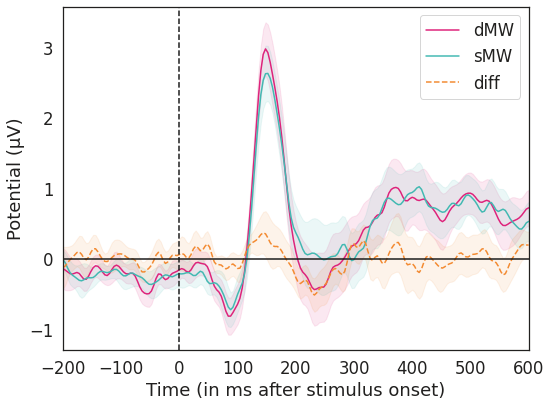

In [117]:
tmax = 0.6
diff = (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale)
diff_std =  stats.sem(contrasts[0] - contrasts[1]) * scale

fig, ax = plt.subplots(1)
scale = 1e6

ax.plot(epochs.times * 1000, np.mean(contrasts[0],axis = 0) * scale,
        color= pink, label='dMW')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[0],axis = 0) - stats.sem(contrasts[0],axis = 0)) * scale,  
                 (np.mean(contrasts[0],axis = 0) + stats.sem(contrasts[0],axis = 0)) * scale,color= pink, alpha= 0.1)
ax.plot(epochs.times * 1000, np.mean(contrasts[1],axis = 0) * scale,
       color= lblue, label='sMW')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[1],axis = 0) - stats.sem(contrasts[1],axis = 0)) * scale,  
                 (np.mean(contrasts[1],axis = 0) + stats.sem(contrasts[1],axis = 0)) * scale,color= lblue,alpha = 0.1)
ax.plot(epochs.times* 1000, (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale),
        color= orange,label='diff', ls = '--')
plt.fill_between(epochs.times * 1000, diff-diff_std, diff+diff_std , color= orange,alpha = 0.1)

# ax.grid(True)
ax.set(xlim=[-200, 1000 * tmax], xlabel='Time (in ms after stimulus onset)',
#        ylim=[-12.5, 5],
       ylabel=u'Potential (μV)')
ax.axvline(0, ls='--', color='k')
ax.axhline(0, ls='-', color='k')

plt.legend()

fig.tight_layout(pad=0.5)

plt.savefig('Figs/erp_dmw_vs_smw.png')
plt.show()

In [118]:
adjacency, ch_names = find_ch_adjacency(epochs.info, 'eeg')
# adjacency = spmatrix(adjacency)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64


Text(0.5, 1.0, 'Between-sensor adjacency')

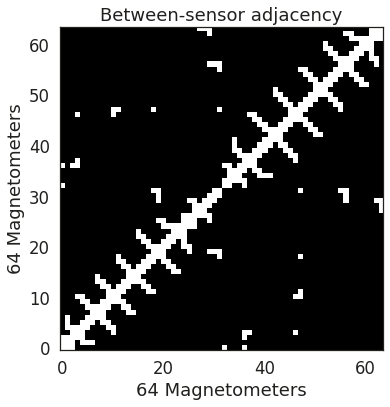

In [119]:
plt.imshow(adjacency.toarray(), cmap='gray', origin='lower',
           interpolation='nearest')
plt.xlabel('{} Magnetometers'.format(len(ch_names)))
plt.ylabel('{} Magnetometers'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [78]:
from mne.stats import spatio_temporal_cluster_test

In [97]:
threshold = None
T_obs, clusters, cluster_p_values, H0 = \
spatio_temporal_cluster_test([np.array(evoked_dmw).reshape((len(evoked_dmw),201,64)),np.array(evoked_smw).reshape((len(evoked_smw),201,64))], n_permutations=1000,
                         threshold=threshold, tail=1, n_jobs=1,
                         adjacency= adjacency,
                         out_type='mask')
    

Using a threshold of 4.600110
stat_fun(H1): min=0.000000 max=7.375675
Running initial clustering
Found 11 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


# Go/Nogo sanity check

In [103]:
go = []
nogo = [] 

for i in all_participants:
    participant = i

    folder = path + participant +'/'
    
    #############################
    #### With ERP SUBTRACTED ####
    #############################
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif', verbose = False) 
    epochs.info['description'] = 'biosemi/64' #necessary for wSMI x
    epochs =  epochs.pick_types(eeg = True) #EOGs break everything\
    
    evoked_go= epochs['go/correct'].average().data
    go.append(evoked_go)
    evoked_nogo= epochs['nogo/correct'].average().data
    nogo.append(evoked_nogo)

In [104]:
go = np.array(go)[:,idx,:]
nogo = np.array(nogo)[:,idx,:]

In [105]:
go_grand_average = np.mean(go, axis = 1)
nogo_grand_average = np.mean(nogo, axis = 1)

contrasts = [ go_grand_average,nogo_grand_average]

In [106]:
T, pval = stats.ttest_rel(contrasts[0],contrasts[1], axis  =0)
alpha = 0.05

n_tests,  n_samples= np.array(contrasts[0]).shape
threshold_uncorrected = stats.t.ppf(1.0 - alpha, n_samples - 1)

reject_bonferroni, pval_bonferroni = bonferroni_correction(pval, alpha=alpha)
threshold_bonferroni = stats.t.ppf(1.0 - alpha / n_tests, n_samples - 1)

reject_fdr, pval_fdr = fdr_correction(pval, alpha=alpha, method='indep')
threshold_fdr = np.min(np.abs(T)[reject_fdr])

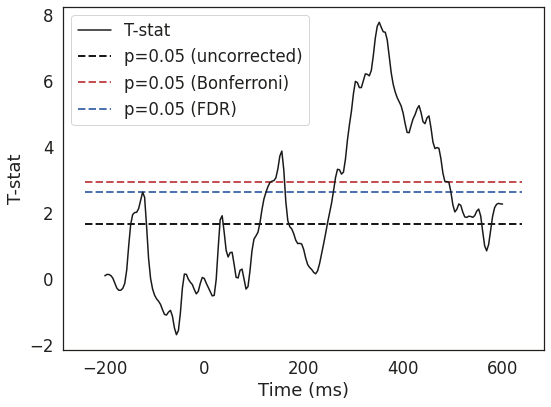

In [107]:
times = 1e3 * epochs.times

plt.close('all')
plt.plot(times, T, 'k', label='T-stat')
xmin, xmax = plt.xlim()
plt.hlines(threshold_uncorrected, xmin, xmax, linestyle='--', colors='k',
           label='p=0.05 (uncorrected)', linewidth=2)
plt.hlines(threshold_bonferroni, xmin, xmax, linestyle='--', colors='r',
           label='p=0.05 (Bonferroni)', linewidth=2)
plt.hlines(threshold_fdr, xmin, xmax, linestyle='--', colors='b',
           label='p=0.05 (FDR)', linewidth=2)
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("T-stat")
plt.show()

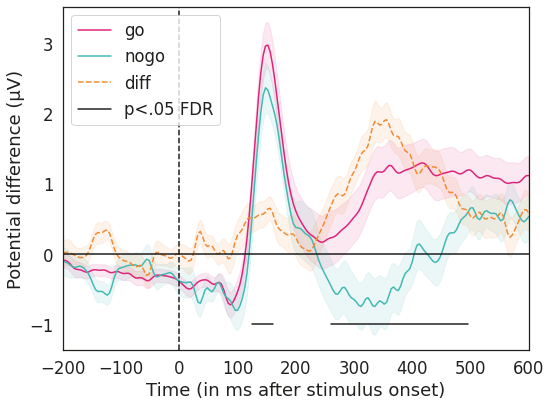

In [112]:
tmax = 0.6
scale = 1e6

p = np.where(pval_fdr < 0.05, -1, None)

diff = (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale)
diff_std =  stats.sem(contrasts[0] - contrasts[1]) * scale

fig, ax = plt.subplots(1)


ax.plot(epochs.times * 1000, np.mean(contrasts[0],axis = 0) * scale,
        color = pink, label='go')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[0],axis = 0) - stats.sem(contrasts[0],axis = 0)) * scale,  
                 (np.mean(contrasts[0],axis = 0) + stats.sem(contrasts[0],axis = 0)) * scale, color = pink, alpha= 0.1)
ax.plot(epochs.times * 1000, np.mean(contrasts[1],axis = 0) * scale,
        color = lblue, label='nogo')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[1],axis = 0) - stats.sem(contrasts[1],axis = 0)) * scale,  
                 (np.mean(contrasts[1],axis = 0) + stats.sem(contrasts[1],axis = 0)) * scale, color = lblue,alpha = 0.1)
ax.plot(epochs.times* 1000, (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale),
        color = orange, label='diff', ls = '--')
plt.fill_between(epochs.times * 1000, diff-diff_std, diff+diff_std , color = orange,alpha = 0.1)


ax.plot(epochs.times * 1000, p, color = grey, label = 'p<.05 FDR')

# ax.grid(True)
ax.set(xlim=[-200, 1000 * tmax], xlabel='Time (in ms after stimulus onset)',
#        ylim=[-12.5, 5],
       ylabel=u'Potential difference (μV)')
ax.axvline(0, ls='--', color='k')
ax.axhline(0, ls='-', color='k')

plt.legend()

fig.tight_layout(pad=0.5)

plt.savefig('erp_go_nogo.png')

In [135]:
a = pd.DataFrame(np.array([epochs.times*100,np.mean(contrasts[0],axis = 0) * scale, np.mean(contrasts[1],axis = 0) * scale, 
]).T)